# Introduction

* This report represents the analysis over the provided dataset, named the "PAMAP2_Dataset: Physical Activity Monitoring", which contains various activities. The Dataset took input from 9 subjects' chest, ankles, and hands to monitor magnetic, inertial, and acceleration information. These inertial measurement units (IMU) were taken using devices such as a gyroscope, magnetometer, and accelerometer.
* The aims of the report were to develop hardware and/or software that can determine the amount (using start/end times and heart rates) and type of physical activity carried out by an individual.
* The first part of this report is data cleaning that will contain:
 * Removing data with 0 activityID.
 * Replacing the nan values using interpolate.
 * Modify IMU features as a vector sum for easier use.
 * Implementation of rollsum concept for IMU features will be explained further in the project.
* Exploratory Data Analysis will be performed with the motivation that was specified at the beginning of the report: we want to find correlations between features to check for redundancy as well as examine feature utility. The purpose of this will be to inform wearable technology companies about the trade-off that can be achieved between production cost and product accuracy.
* Next, we investigate the heart rate data and observe that it appears fairly separable over the activity categories. This forms our hypothesis that we test later on in the document. This hypothesis states that there will be a mass difference in heart rate values of categories 'light' activities between 'moderate' activities and category moderate activities between hard activities, indicating that there is a noticeable difference in heart rate between more exhausting activities. This is validated using a z-test.
* A machine learning model is trained and tested using a number of sets of features from the dataset that will be created from the mean heart rates. The idea behind this is that we are presenting the theoretical tech company with a variety of features to use in hardware products along with the accuracies resulting in the use of these features. A KNN model was used and the accuracies are detailed in the section of the model, below.

# Importing  Packages

In [1]:
import pandas as pd
import numpy as np
import sys
import math
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,recall_score, f1_score, confusion_matrix,roc_auc_score,roc_curve, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import pinv
from scipy.spatial.distance import euclidean, cdist
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

In [3]:
activities = {0: 'transient',
                  1: 'lying',
                  2: 'sitting',
                  3: 'standing',
                  4: 'walking',
                  5: 'running',
                  6: 'cycling',
                  7: 'Nordic_walking',
                  9: 'watching_TV',
                  10: 'computer_work',
                  11: 'car_driving',
                  12: 'ascending_stairs',
                  13: 'descending_stairs',
                  16: 'vacuum_cleaning',
                  17: 'ironing',
                  18: 'folding_laundry',
                  19: 'house_cleaning',
                  20: 'playing_soccer',
                  24: 'rope_jumping' }

col = ["timestamp", "activityID","HR"]

hand = ['handTemperature', 
           'handAcc16X', 'handAcc16Y', 'handAcc16Z', 
           'handAcc6X', 'handAcc6Y', 'handAcc6Z', 
           'handGyroX', 'handGyroY', 'handGyroZ', 
           'handMagneX', 'handMagneY', 'handMagneZ',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']
chest = ['chestTemperature', 
           'chestAcc16X', 'chestAcc16Y', 'chestAcc16Z', 
           'chestAcc6X', 'chestAcc6Y', 'chestAcc6Z', 
           'chestGyroX', 'chestGyroY', 'chestGyroZ', 
           'chestMagneX', 'chestMagneY', 'chestMagneZ',
           'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

ankle = ['ankleTemperature', 
           'ankleAcc16X', 'ankleAcc16Y', 'ankleAcc16Z', 
           'ankleAcc6X', 'ankleAcc6Y', 'ankleAcc6Z', 
           'ankleGyroX', 'ankleGyroY', 'ankleGyroZ', 
           'ankleMagneX', 'ankleMagneY', 'ankleMagneZ',
           'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

columns = col + hand + chest + ankle  

In the data collection protocol of the dataset documents,they specify the estimated metabolic equivalent of task (MET) for each recorded activity.MET can be used to estimate calories burned per minute, and activities can be grouped into broad categories of intensity.

Instead of predicting specifically what activity each person might be doing (lying, running, laundry, ...) at an exact level this research intends to classify with the aim of predicting what intensity the activity that a person is performing.

For a company to develop hardware and/or software that determine calories burned, for example, one should take into consideration the individual differences such as height, weight, age, etc. This goes far beyond anatomy/biology and is outside of the scope of this project. Nonetheless, the MET data is a good measure for measuring physical effort.

**For** **classifying** **MET :**

Activities with a MET value less than 3 are considered light-intensity activities. A MET value between 3 and 6 inclusive are considered moderate-intensity activities, whilst a MET value of over 6 indicates high intensity(hard).





In [4]:
LightActIDs = [1, 2, 3, 9, 10, 11, 17, 18]

ModerateActIDs = [4, 6, 7, 13, 16, 19]

HardActIDs = [5, 12, 20, 24]

def intensity(actid):
    if actid in LightActIDs:
        return 1 # Light activities
    if actid in ModerateActIDs:
        return 2  # Moderate activities
    if actid in HardActIDs:
        return 3 # Hard activities
    

# Importing Data

In [5]:
df=pd.DataFrame()

In [6]:
protcol = [
    'subject101.dat',
    'subject102.dat',
    'subject103.dat',
    'subject104.dat',
    'subject105.dat',
    'subject106.dat',
    'subject107.dat',
    'subject108.dat',
    'subject109.dat',
]
df = pd.DataFrame()
num=1
for file in protcol:
    table = pd.read_table(file, header=None, sep='\s+')
    table.columns = columns
    table['subjectID'] = num
    num+=1
    table['categoryID'] = table['activityID'].apply(intensity)

    df = df.append(table, ignore_index=True)

In [8]:
optional=[
    'subject101op.dat',
    'subject105op.dat',
    'subject106op.dat',
    'subject108op.dat',
    'subject109op.dat'
]

num=[1,5,6,8,9]
for i,file in enumerate(optional):
    table = pd.read_table(file, header=None, sep='\s+')
    table.columns = columns
    table['subjectID'] = num[i]
    table['categoryID'] = table['activityID'].apply(intensity)
    df = df.append(table, ignore_index=True)

In [9]:
df

,timestamp,activityID,HR,handTemperature,handAcc16X,handAcc16Y,handAcc16Z,handAcc6X,handAcc6Y,handAcc6Z,...,ankleGyroZ,ankleMagneX,ankleMagneY,ankleMagneZ,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subjectID,categoryID
0,8.38,0,104.0,30.000,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,-0.017580,-61.1888,-38.9599,-58.1438,1.000000,0.000000,0.000000,0.000000,1,NaN
1,8.39,0,NaN,30.000,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,0.000368,-59.8479,-38.8919,-58.5253,1.000000,0.000000,0.000000,0.000000,1,NaN
2,8.40,0,NaN,30.000,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.022495,-60.7361,-39.4138,-58.3999,1.000000,0.000000,0.000000,0.000000,1,NaN
3,8.41,0,NaN,30.000,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,0.011275,-60.4091,-38.7635,-58.3956,1.000000,0.000000,0.000000,0.000000,1,NaN
4,8.42,0,NaN,30.000,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.002823,-61.5199,-39.3879,-58.2694,1.000000,0.000000,0.000000,0.000000,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3850500,1940.78,0,NaN,24.875,-6.51915,6.87682,2.34395,-6.67159,6.87843,2.50735,...,-0.016737,-40.1550,-18.4177,25.3998,0.276396,-0.692785,0.412759,-0.522766,9,NaN
3850501,1940.79,0,NaN,24.875,-6.47548,6.95375,2.49829,-6.71706,6.87873,2.47720,...,-0.015746,-39.7605,-18.8227,25.6854,0.276461,-0.692737,0.412749,-0.522804,9,NaN
3850502,1940.80,0,NaN,24.875,-6.58698,6.84148,2.57398,-6.79405,6.81875,2.34150,...,0.001916,-39.3718,-19.0996,25.6871,0.276468,-0.692669,0.412555,-0.523042,9,NaN
3850503,1940.81,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.006604,-39.5070,-18.9654,25.2609,0.276608,-0.692688,0.412525,-0.522966,9,NaN


# Data Cleaning

In the dataset documents, they detail some redundant features. The orientation feature for all IMU's is invalid in this dataset. They also note that the 6G accelerometers are exposed to over-saturation when sharing more than 6G. For this reason, these columns will be dropped from the dataset.

In [12]:
RedundantColumns = [
          'handAcc6X', 'handAcc6Y', 'handAcc6Z',
          'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
          'chestAcc6X', 'chestAcc6Y', 'chestAcc6Z', 
          'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
          'ankleAcc6X', 'ankleAcc6Y', 'ankleAcc6Z', 
          'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'
          ]

df.drop(columns=RedundantColumns, inplace=True)

ActivityID 0 is to be removed, as it was mentioned in the pdf provided with the dataset that it was a "transitive" feature, and included a mix of data at different time steps.

In [13]:
data = df[df["activityID"] != 0]
data

,timestamp,activityID,HR,handTemperature,handAcc16X,handAcc16Y,handAcc16Z,handGyroX,handGyroY,handGyroZ,...,ankleAcc16Y,ankleAcc16Z,ankleGyroX,ankleGyroY,ankleGyroZ,ankleMagneX,ankleMagneY,ankleMagneZ,subjectID,categoryID
2928,37.66,1,NaN,30.375,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,...,-1.847610,0.095156,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,1,1.0
2929,37.67,1,NaN,30.375,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,...,-1.884380,-0.020804,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,1,1.0
2930,37.68,1,NaN,30.375,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,...,-1.922030,-0.059173,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,1,1.0
2931,37.69,1,NaN,30.375,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,...,-1.847140,0.094385,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,1,1.0
2932,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,...,-1.885820,0.095775,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3850036,1936.14,20,NaN,24.875,-6.42779,6.84232,2.80728,-0.021124,0.107389,0.043537,...,-0.561116,-3.660880,-0.013752,0.011737,-0.011313,-39.3605,-19.4856,25.9712,9,3.0
3850037,1936.15,20,NaN,24.875,-6.39107,6.69028,2.80834,0.020008,0.105153,0.027290,...,-0.183274,-3.469820,-0.009593,-0.014075,-0.052507,-38.7226,-19.7765,25.4065,9,3.0
3850038,1936.16,20,NaN,24.875,-6.41763,6.57977,3.15471,-0.014853,0.079020,0.041868,...,-0.069368,-3.470520,-0.010825,-0.025462,-0.057343,-39.3523,-19.8722,25.9717,9,3.0
3850039,1936.17,20,NaN,24.875,-6.46049,6.42730,3.03912,0.012556,0.068029,0.050227,...,-0.182800,-3.470590,-0.019402,-0.002942,-0.033522,-38.7082,-20.1618,25.9743,9,3.0


In [15]:
data.isnull().sum()

timestamp                 0
activityID                0
HR                  2476126
handTemperature       11868
handAcc16X            11868
handAcc16Y            11868
handAcc16Z            11868
handGyroX             11868
handGyroY             11868
handGyroZ             11868
handMagneX            11868
handMagneY            11868
handMagneZ            11868
chestTemperature       3058
chestAcc16X            3058
chestAcc16Y            3058
chestAcc16Z            3058
chestGyroX             3058
chestGyroY             3058
chestGyroZ             3058
chestMagneX            3058
chestMagneY            3058
chestMagneZ            3058
ankleTemperature       9867
ankleAcc16X            9867
ankleAcc16Y            9867
ankleAcc16Z            9867
ankleGyroX             9867
ankleGyroY             9867
ankleGyroZ             9867
ankleMagneX            9867
ankleMagneY            9867
ankleMagneZ            9867
subjectID                 0
categoryID                0
dtype: int64

* Each different activity has NaN values for various subjects. The heart rate monitor has a sampling rate of ~9Hz. The IMU devices have a sampling rate of ~100Hz. This is the reason that there are more NaN values for the heart rate feature than for the IMU columns,Therefore some data filling has to be applied. It is best to use interpolate which is constructing a new data point out of a set of known data points.
* The interpolation for this dataset must be performed per subject, per activity. This is important to make sure that there are no confounding variables by interpolating across activities with very different MET values. So first the data will be sorted to the respect of **subjectID** and **timestamp**, and then interpolate should be done. 

In [16]:
data=data.sort_values(by=['subjectID','timestamp'])
data=data.interpolate()
data.isnull().sum()

timestamp           0
activityID          0
HR                  4
handTemperature     0
handAcc16X          0
handAcc16Y          0
handAcc16Z          0
handGyroX           0
handGyroY           0
handGyroZ           0
handMagneX          0
handMagneY          0
handMagneZ          0
chestTemperature    0
chestAcc16X         0
chestAcc16Y         0
chestAcc16Z         0
chestGyroX          0
chestGyroY          0
chestGyroZ          0
chestMagneX         0
chestMagneY         0
chestMagneZ         0
ankleTemperature    0
ankleAcc16X         0
ankleAcc16Y         0
ankleAcc16Z         0
ankleGyroX          0
ankleGyroY          0
ankleGyroZ          0
ankleMagneX         0
ankleMagneY         0
ankleMagneZ         0
subjectID           0
categoryID          0
dtype: int64

The reason why heart rate still has NaN values is that interpolation calculates the values around the NaN cell. Since the first cells are NaN it is normal to generate new NaN values after interpolation. To solve this problem we can assume that the value of the first 4 cells is 100 since the values after index 4 are 100. Doing so will eliminate any NaN values from our dataset.

In [20]:
for i in range(4):
    data["HR"].iloc[i]=100
data.isnull().sum()

C:\Users\hesam\anaconda3\envs\new\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


timestamp           0
activityID          0
HR                  0
handTemperature     0
handAcc16X          0
handAcc16Y          0
handAcc16Z          0
handGyroX           0
handGyroY           0
handGyroZ           0
handMagneX          0
handMagneY          0
handMagneZ          0
chestTemperature    0
chestAcc16X         0
chestAcc16Y         0
chestAcc16Z         0
chestGyroX          0
chestGyroY          0
chestGyroZ          0
chestMagneX         0
chestMagneY         0
chestMagneZ         0
ankleTemperature    0
ankleAcc16X         0
ankleAcc16Y         0
ankleAcc16Z         0
ankleGyroX          0
ankleGyroY          0
ankleGyroZ          0
ankleMagneX         0
ankleMagneY         0
ankleMagneZ         0
subjectID           0
categoryID          0
dtype: int64

As we can see, there are no more missing values

* The new features that are created in this section are associated to the data collected from each IMU. These devices collected accelerometer, gyroscope, and magnetometer data for each (x,y,z) direction.

* Whilst this is useful data in understanding positional change of the device, the numbers on their own are not very useful for predictions. This idea is because these features need to have some temporal relation to each other. That is to say for example, an accelerometer value of 2G is not as informative as knowing the sum of accelerometer values over the last 0.05 seconds.

* These new features create a rolling sum of values in each direction x,y,z for each data type of each IMU over the previous 0.05 seconds. This issue can be done because the sampling rate is 100Hz, I.e 100 samples per second. Hence we can perform a rolling sum with a window of 5 to get the 0.05 second total.

In [21]:
features = [
           'handAcc16X', 'handAcc16Y', 'handAcc16Z',
           'handGyroX', 'handGyroY', 'handGyroZ', 
           'handMagneX', 'handMagneY', 'handMagneZ',
           'chestAcc16X', 'chestAcc16Y', 'chestAcc16Z',
           'chestGyroX', 'chestGyroY', 'chestGyroZ', 
           'chestMagneX', 'chestMagneY', 'chestMagneZ',
           'ankleAcc16X', 'ankleAcc16Y', 'ankleAcc16Z', 
           'ankleGyroX', 'ankleGyroY', 'ankleGyroZ', 
           'ankleMagneX', 'ankleMagneY', 'ankleMagneZ'
           ]
NewFeatures = []

for col in features:
    chg_col = col+"RollSum"
    NewFeatures.append(chg_col) 
dfcopy = data.copy()

#This creates the new columns for the rolling sum features
for col in NewFeatures:
    dfcopy[col] = 0
dfcopy

,timestamp,activityID,HR,handTemperature,handAcc16X,handAcc16Y,handAcc16Z,handGyroX,handGyroY,handGyroZ,...,chestMagneZRollSum,ankleAcc16XRollSum,ankleAcc16YRollSum,ankleAcc16ZRollSum,ankleGyroXRollSum,ankleGyroYRollSum,ankleGyroZRollSum,ankleMagneXRollSum,ankleMagneYRollSum,ankleMagneZRollSum
2928,37.66,1,100.0,30.375,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,...,0,0,0,0,0,0,0,0,0,0
2929,37.67,1,100.0,30.375,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,...,0,0,0,0,0,0,0,0,0,0
2930,37.68,1,100.0,30.375,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,...,0,0,0,0,0,0,0,0,0,0
2931,37.69,1,100.0,30.375,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,...,0,0,0,0,0,0,0,0,0,0
2932,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3850036,1936.14,20,178.0,24.875,-6.42779,6.84232,2.80728,-0.021124,0.107389,0.043537,...,0,0,0,0,0,0,0,0,0,0
3850037,1936.15,20,178.0,24.875,-6.39107,6.69028,2.80834,0.020008,0.105153,0.027290,...,0,0,0,0,0,0,0,0,0,0
3850038,1936.16,20,178.0,24.875,-6.41763,6.57977,3.15471,-0.014853,0.079020,0.041868,...,0,0,0,0,0,0,0,0,0,0
3850039,1936.17,20,178.0,24.875,-6.46049,6.42730,3.03912,0.012556,0.068029,0.050227,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#Iterating through each subject ID
for subjectID in range(1,10):
    print("subject:",subjectID)

    #Iterating through each activity type
    for actID,value in activities.items():
        #If we have data for this subject and activity
            #Get this data
            temp_dframe = dfcopy[dfcopy["activityID"] == actID]
            temp_dframe = temp_dframe[temp_dframe["subjectID"]==subjectID]

            #Create the columns in the new data
            for col in features:
                chg_col = col+"RollSum"
                #This performs the rolling sum to create the new features
                temp_dframe[chg_col] = temp_dframe[col].rolling(5, min_periods=1).sum()

            
            #This adds this generated dataset to the original dataset
            interp_idx = temp_dframe.index
            dfcopy.loc[interp_idx] = temp_dframe.loc[interp_idx]

subject: 1
subject: 2
subject: 3
subject: 4
subject: 5
subject: 6
subject: 7
subject: 8
subject: 9


Through feature analysis, it was found that whilst these rolling sum features did not correlate strongly with the activity type on their own, the summed value of these did. This value is created by summing the absolute values in each direction for the IMU rolling sum features.

In [23]:
i=0
for j in range(9) :
    dfcopy[features[i][:-1]+'VecSum']=dfcopy[features[i]+"RollSum"].abs() + dfcopy[features[i+1]+"RollSum"].abs() + dfcopy[features[i+2]+"RollSum"].abs()
    i+=3
dfcopy.drop(columns = features, inplace=True)
dfcopy.drop(columns = NewFeatures, inplace=True)
dfcopy

,timestamp,activityID,HR,handTemperature,chestTemperature,ankleTemperature,subjectID,categoryID,handAcc16VecSum,handGyroVecSum,handMagneVecSum,chestAcc16VecSum,chestGyroVecSum,chestMagneVecSum,ankleAcc16VecSum,ankleGyroVecSum,ankleMagneVecSum
2928,37.66,1,100.0,30.375,32.1875,30.7500,1,1.0,16.08198,0.053474,96.84010,11.426322,0.106019,95.567266,11.681316,0.032374,156.3413
2929,37.67,1,100.0,30.375,32.1875,30.7500,1,1.0,31.79149,0.260201,195.29060,22.927263,0.176390,190.522956,23.242512,0.058319,311.9182
2930,37.68,1,100.0,30.375,32.1875,30.7500,1,1.0,47.04821,0.508825,291.25576,34.802590,0.244403,285.725236,34.801699,0.093670,466.6550
2931,37.69,1,100.0,30.375,32.1875,30.7500,1,1.0,62.30916,0.707416,389.18164,46.491257,0.323729,379.860920,46.406924,0.171977,622.4023
2932,37.70,1,100.0,30.375,32.1875,30.7500,1,1.0,77.96138,0.754468,485.60610,58.254502,0.376671,473.957037,58.164299,0.213176,777.6135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3850036,1936.14,20,178.0,24.875,32.3125,31.6875,9,3.0,80.46177,0.721093,400.89977,71.130230,1.321646,392.831630,66.795692,0.333056,421.8503
3850037,1936.15,20,178.0,24.875,32.3125,31.6875,9,3.0,80.12408,0.791012,400.11800,70.794880,1.253799,392.965720,66.758775,0.236593,421.1886
3850038,1936.16,20,178.0,24.875,32.3125,31.6875,9,3.0,80.19887,0.770567,399.23250,70.869610,1.288009,393.252480,66.271928,0.130621,421.4060
3850039,1936.17,20,178.0,24.875,32.3125,31.6875,9,3.0,80.16093,0.703309,398.96180,70.904740,1.294899,392.362350,65.821452,0.225413,422.9898


In [24]:
dfcopy.isnull().sum()

timestamp           0
activityID          0
HR                  0
handTemperature     0
chestTemperature    0
ankleTemperature    0
subjectID           0
categoryID          0
handAcc16VecSum     0
handGyroVecSum      0
handMagneVecSum     0
chestAcc16VecSum    0
chestGyroVecSum     0
chestMagneVecSum    0
ankleAcc16VecSum    0
ankleGyroVecSum     0
ankleMagneVecSum    0
dtype: int64

# Exploratory Data Analysis

According to the diagram below, each activity is plotted with its corresponding average heartrate and is divided into light, moderate and hard categories. It can be seen visually that the average heartrate increases almost as the activities harden.

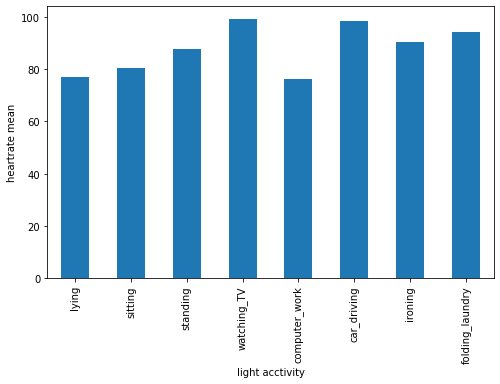

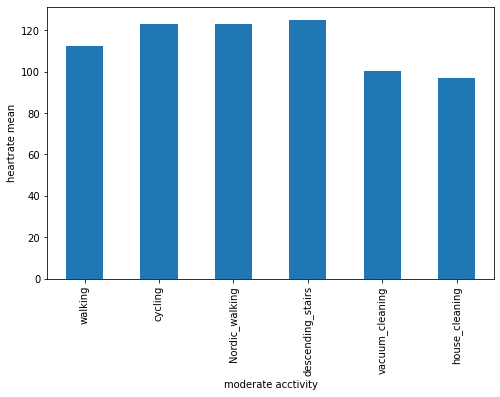

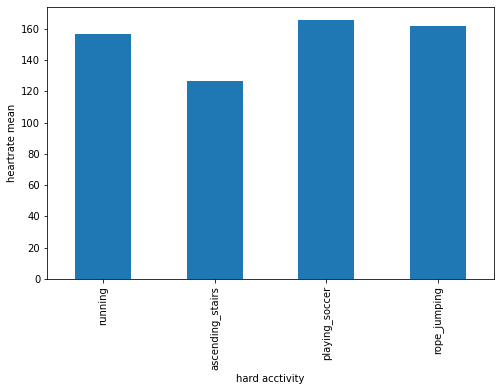

In [235]:
for value,typ in {1:'light',2:'moderate',3:'hard'}.items() :  
    dff=dfcopy[dfcopy['categoryID']==value]
    dff=dff.groupby('activityID')['HR'].mean()
    dff.index=dff.index.map(activities)
    dff.plot(kind='bar',figsize=(8,5))
    plt.xlabel(typ+' acctivity')
    plt.ylabel("heartrate mean")                 
    plt.show()     


* The chart below plots the heart rate for each subject at each instance of the activity performed by that subject.
* It can be seen that the graphs are relatively ascending, ie in each subject the heart rate increases with increasing time.

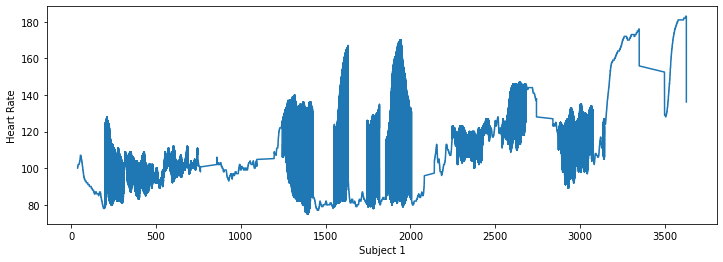

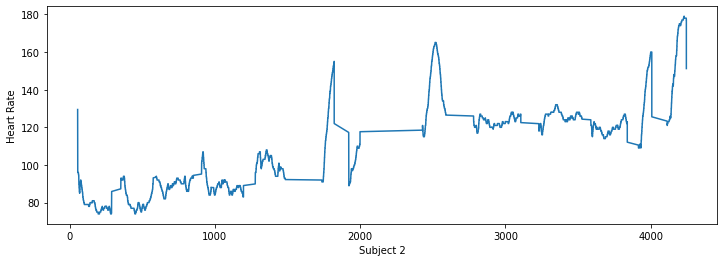

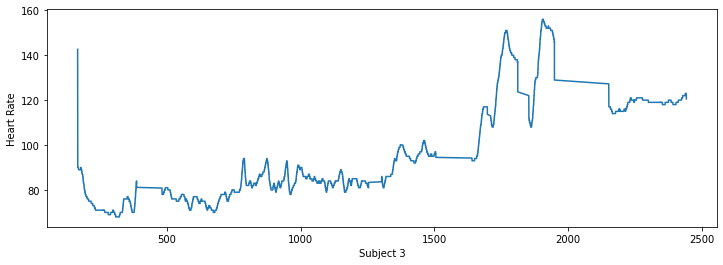

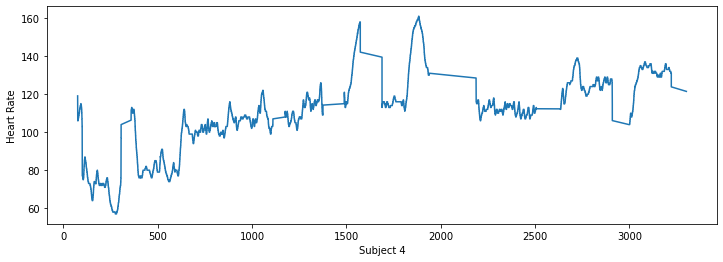

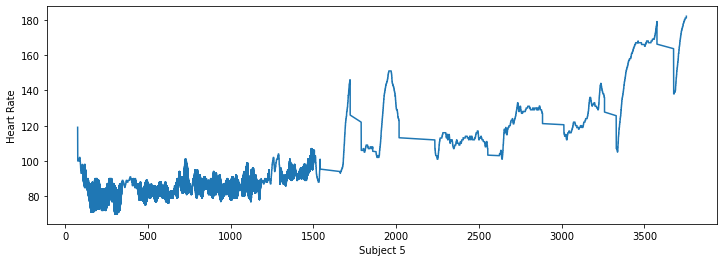

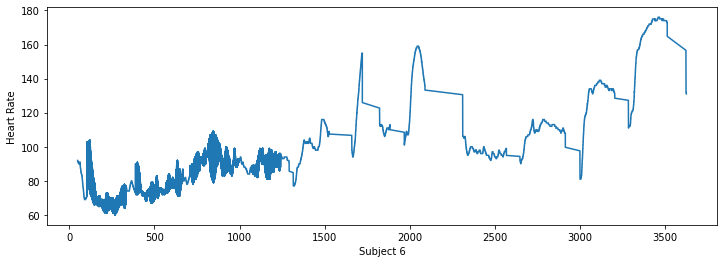

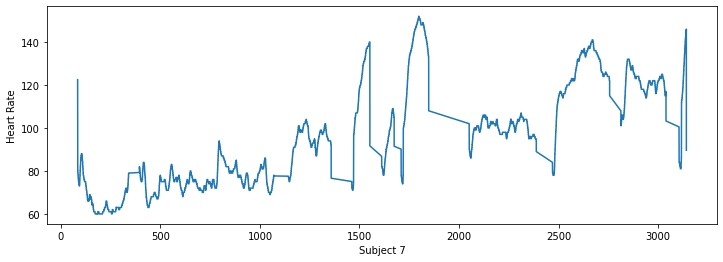

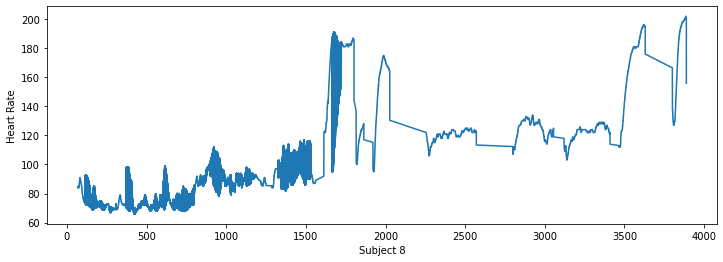

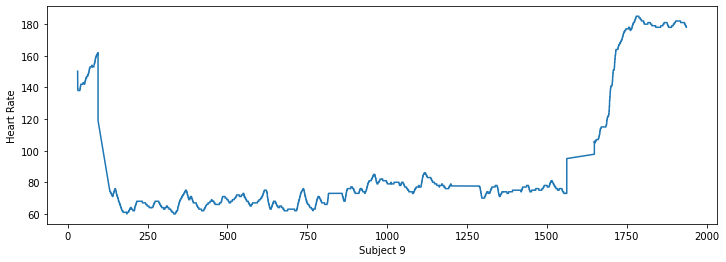

In [25]:
for i in range(1,10):
    dff=dfcopy[dfcopy['subjectID']==i]
    plt.subplots(figsize=(12,4))
    plt.plot(dff['timestamp'],dff['HR'])
    plt.xlabel('Subject '+str(i))
    plt.ylabel("Heart Rate") 
    plt.show()


According to the chart below, it can be seen that subjects 1, 8 and 5 performed more activities than the other subjects.
They also have a relatively high mean heart rate, so they probably had more physical activity than the rest of the subjects. 

In [31]:
dfcopy.groupby('subjectID')["HR"].describe().sort_values(by='count',ascending=False)


,count,mean,std,min,25%,50%,75%,max
subjectID,,,,,,,,
1,469325.0,110.870062,21.702529,75.0,97.000000,106.6,121.0,183.0
8,414294.0,103.590890,32.049139,66.0,76.727273,93.0,122.0,202.0
5,411813.0,101.097907,24.008149,70.0,84.444444,90.0,113.0,182.0
6,362373.0,96.829262,25.657232,60.0,78.266667,92.0,106.0,176.0
2,263349.0,109.492739,24.230703,74.0,89.000000,110.0,125.0,179.0
7,232776.0,96.390682,24.045926,60.0,75.000000,96.0,117.0,152.0
4,231421.0,109.434140,20.721957,57.0,101.000000,111.0,123.0,161.0
3,174338.0,95.105546,21.958823,68.0,79.000000,86.0,115.0,156.0
9,165264.0,90.973557,39.211881,60.0,68.000000,75.0,81.0,185.0


* According to the chart below, it can be concluded that most datasets contain data with categorylD light and moderate (1,2), so it can be concluded that few people have done all hard activities.

* Of course, as we know, the number of light and moderate activities is more than hard, but although the ratio of the number of light activities to the ratio of hard activities is two, here the ratio of light activities to hard activities is almost 4.3, on the other hand, the ratio Light activities to moderate activities were about 1.3, which is 1.3 here. Therefore, it can be concluded that the subjects performed light and moderate activities with relatively equal proportions, but only a small number of them performed all hard activities. 

* Also in this chart, you can see that the average heartrates increase as the activities become more difficult.

In [240]:
dfcopy.groupby('categoryID')["HR"].describe()

,count,mean,std,min,25%,50%,75%,max
categoryID,,,,,,,,
1.0,1354310.0,84.725313,13.434455,57.0,75.0,83.230769,92.0,163.307692
2.0,1058953.0,112.518931,17.010715,68.0,99.0,114.000000,124.0,175.000000
3.0,311690.0,147.547509,27.848855,71.0,125.0,151.000000,172.0,202.000000


* The chart below shows the correlation of each column with the other. 
* It can be seen that **heartrate(HR)** has a high positive correlation with **categoryID** and **timestamp**.
* Also **handTemperature** has a relatively negative correlation with **categoryID**. 

<AxesSubplot:>

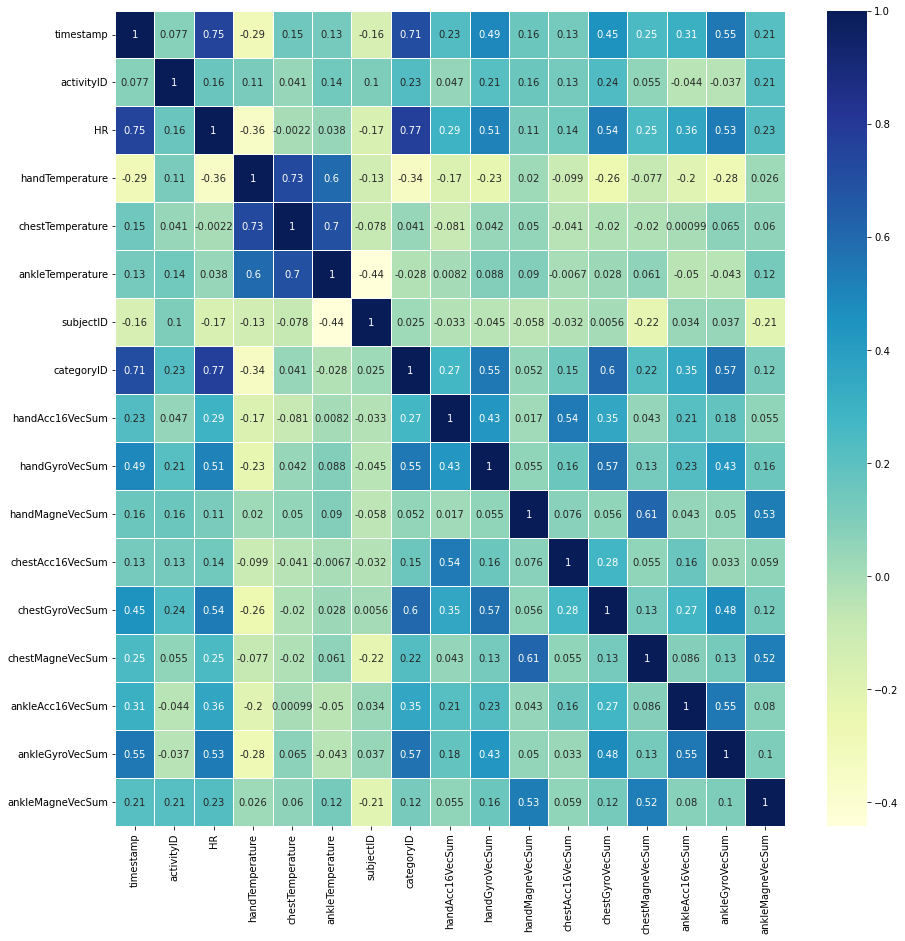

In [237]:
correlations = dfcopy.corr()
f,ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlations, annot=True, cmap="YlGnBu", linewidths=.5)

# Hypothesis 

In the EDA section of the project, the relationship between haertrate and categoryID was mentioned several times, and in the last chart, which was a correlation coefficient diagram, we saw that heartrate was positively correlated with categoryID .So in this section I will test the correctness of this hypothesis.

To do this, I first divide the data into two parts, DevData( %80 of data) and TestData(%20 of data).

In [33]:
DevData = dfcopy.sample(frac=0.8)
TestData = dfcopy.drop(DevData.index)
dff=TestData

If there is a positive correlation between category ID and heart rate, then by increasing the average heart rate, its categoryID should also increase. For this purpose, we perform two hypothesis tests (A and B).

# A) If HR is correlated with Activity Intensity, then Moderate activities should have a higher mean HR than Light activities.

**Null Hypothesis:**

 * $H_0$ : The mean heart rate of the moderate activities is less than the mean heart rate of light activities or there is no difference between them. 


**Alternative Hypothesis:**

* $H_1$ : The mean heart rate of the moderate activities is more than the mean of light activities.


$H_0: μ_1 - μ_2 \geq 0$

$H_1: μ_1 - μ_2 < 0$


$D $~$ N (μ_1 - μ_2 , \frac{σ_1^2}{n_1} + \frac{σ_2^2}{n_2})$

In [181]:
sc=pd.DataFrame([list(hr_means[:2]),list(hr_std[:2]),list(hr_count[:2])])
sc.index=['mean','std','count']
sc.columns=['Light','moderate']
sc

,Light,moderate
mean,84.748092,112.532232
std,13.456111,17.014432
count,272095.000000,210873.000000


In [34]:
hr_means=dff.groupby('categoryID')['HR'].mean()
hr_std=dff.groupby('categoryID')['HR'].std()
hr_count=dff.groupby('categoryID')['HR'].count()
combinederror=(((hr_std[1]**2)/hr_count[1])+((hr_std[2]**2)/hr_count[2]))**0.5   
z=(hr_means[2]-hr_means[1])/combinederror
z

616.6816247765188

In [37]:
p_value_from_normal_for_diff = (1-stats.norm.cdf(z))
print ('P-value is :' ,p_value_from_normal_for_diff)

P-value is : 0.0


* With a resulting p-value of 0, the null hypothesis can be rejected. As such it can be concluded with good confidence that Moderate activities will have a higher mean HR than light activities 

# B) If HR is correlated with Activity Intensity, then Hard activities should have a higher mean HR than Moderate activities.

**Null Hypothesis:**

 * $H_0$ : The mean heart rate of the hard activities is less than the mean heart rate of moderate activities or there is no difference between them. 


**Alternative Hypothesis:**

* $H_1$ : The mean heart rate of the hard activities is more than the mean of moderate activities.


$H_0: μ_2 - μ_3 \geq 0$

$H_1: μ_2 - μ_3 < 0$


$D $~$ N (μ_2 - μ_3 , \frac{σ_2^2}{n_1} + \frac{σ_3^2}{n_2})$

In [40]:
sc=pd.DataFrame([list(hr_means[2:]),list(hr_std[2:]),list(hr_count[2:])])
sc.index=['mean','std','count']
sc.columns=['moderate','hard']
sc

,moderate,hard
mean,112.479444,147.583799
std,16.973535,27.833318
count,211632.000000,62519.000000


In [41]:
combinederror=(((hr_std[2]**2)/hr_count[2])+((hr_std[3]**2)/hr_count[3]))**0.5   
z=(hr_means[3]-hr_means[2])/combinederror
z

299.3419918435702

In [42]:
p_value_from_normal_for_diff = (1-stats.norm.cdf(z))
print ('P-value is :', p_value_from_normal_for_diff)

P-value is : 0.0


* With a resulting p-value of 0, the null hypothesis can be rejected. As such it can be concluded with good confidence that hard activities will have a higher mean HR than moderate activities

According to the results of the two tests, it can be concluded with good confidence that as the activities become more difficult, the average heart rate increases.

# Model

To develop hardware and/or software which can determine the amount (using start/end times and heart rates) and type of physical activity carried out by an individual, The idea came to me to design a model that takes the individual characteristics (maximum haert rate) of each individual and other available data such as heart rate, timestamp, .. and determines what type of activity is done (light, moderate, hard). For this purpose, I use the knn model and create new data based on the previous data, which includes the timestamp count of each activity for each subject (this indicates the length of time that each subject has performed that activity) and the average of the other column. (Such as heart rate, hand tempreture, ...) for each activity is for the subject. We do not consider the category id column only at this time

In [44]:
MaxHeartrates = [193, 195, 189, 196, 194, 194, 197, 188, 189]
vals=[]
for actid,key in activities.items(): # each activity
     for i in range(1,10): #for each subject
        dta=dfcopy[dfcopy['subjectID']==i]
        itm=[]
        for k in [2,3,4,5,8,9,10,11,12,13,14,15,16]:
            itm.append(dta[dta['activityID']==actid].mean()[k]) #mean of sum column like heart rate temperatures
        itm.append(actid) #appending activityID
        itm.append(MaxHeartrates[i-1]) #apending Max Heartrate for each subject
        itm.append(dta[dta['activityID']==actid].count()[0]) #count of data(use for time column)

        vals.append(itm)
vals

[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0, 193, 0],
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0, 195, 0],
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0, 189, 0],
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0, 196, 0],
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0, 194, 0],
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0, 194, 0],
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0, 197, 0],
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0, 188, 0],
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0, 189, 0],
 [93.50637920255018,
  31.28716160297201,
  33.0797715820061,
  31.695279453415235,
  76.39232029249126,
  1.279113730495978,
  440.11453272662266,
  60.541433660003015,
  0.749609503772302,
  505.9214495768268,
  71.08482784941101,
  0.578374134373679,
  375.09273280237613,
  1,
  193,
 

In [45]:
#define columns
columns=[dfcopy.columns[k] for k in [2,3,4,5,8,9,10,11,12,13,14,15,16] ]
columns.append('activityID')
columns.append('MAX_HR')
columns.append('Time')
columns

['HR',
 'handTemperature',
 'chestTemperature',
 'ankleTemperature',
 'handAcc16VecSum',
 'handGyroVecSum',
 'handMagneVecSum',
 'chestAcc16VecSum',
 'chestGyroVecSum',
 'chestMagneVecSum',
 'ankleAcc16VecSum',
 'ankleGyroVecSum',
 'ankleMagneVecSum',
 'activityID',
 'MAX_HR',
 'Time']

In [47]:
dataset=pd.DataFrame(vals)
dataset.columns=columns

Using this function and the following code, we add the category id column as label, light, moderate, hard. We also delete the nan and activity id columns.

In [48]:
def intensity_str(actid):
    if actid in LightActIDs:
        return 'light' # Light activities
    if actid in ModerateActIDs:
        return 'moderate'  # Moderate activities
    if actid in HardActIDs:
        return 'hard' # Hard activities
dataset['categoryID']=dataset['activityID'].apply(intensity_str)

In [49]:
dataset.dropna(inplace=True)
dataset.drop(columns='activityID',inplace=True)
dataset

,HR,handTemperature,chestTemperature,ankleTemperature,handAcc16VecSum,handGyroVecSum,handMagneVecSum,chestAcc16VecSum,chestGyroVecSum,chestMagneVecSum,ankleAcc16VecSum,ankleGyroVecSum,ankleMagneVecSum,MAX_HR,Time,categoryID
9,93.506379,31.287162,33.079772,31.695279,76.392320,1.279114,440.114533,60.541434,0.749610,505.921450,71.084828,0.578374,375.092733,193,27187,light
10,79.564919,33.672154,36.919334,34.518107,79.114737,1.355406,271.724333,68.890295,0.672423,307.520232,67.633023,0.617929,227.264352,195,23430,light
11,74.042569,31.309690,33.626627,31.670764,76.137910,1.456792,282.001879,56.255654,0.624296,334.882411,56.730077,0.576934,253.754406,189,22044,light
12,74.614894,32.720924,34.697943,33.396255,68.483777,1.059220,376.605050,58.821134,0.687972,366.388929,64.786851,0.580083,273.788948,196,23047,light
13,81.564081,34.817400,36.542288,34.093612,71.839527,0.696537,258.909942,56.852845,0.482421,360.282410,69.068288,0.436481,263.984099,194,23699,light
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,156.029460,28.418114,32.100899,30.281622,98.792126,35.104292,323.366545,83.029470,9.207251,350.495095,85.508104,12.265242,388.271010,195,13262,hard
166,163.555016,33.817632,36.436975,34.094360,108.780979,34.085968,356.706308,77.189308,4.788294,358.877526,103.460537,13.379732,294.492050,194,7733,hard
167,131.655078,27.977051,33.312500,33.937500,74.685904,1.582835,388.251573,56.210392,0.784275,359.537309,60.073334,0.245272,417.603905,194,256,hard
169,174.364989,30.825531,34.132467,31.689104,101.188977,35.522689,365.964819,82.541396,6.142234,344.311037,115.249100,19.976298,420.734389,188,8806,hard


* Split our dataset into its attributes and labels.The X variable contains the first 15 columns of the dataset (i.e. attributes) while y contains the labels.
* To avoid over-fitting, we will divide our dataset into training and test splits, which gives us a better idea as to how our algorithm performed during the testing phase. This way our algorithm is tested on un-seen data, as it would be in a production application.

In [52]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, 15].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)


Before making any actual predictions, it is always a good practice to scale the features so that all of them can be uniformly evaluated.The gradient descent algorithm (which is used in neural network training and other machine learning algorithms) also converges faster with normalized features.

In [53]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


It is extremely straight forward to train the KNN algorithm and make predictions with it, especially when using Scikit-Learn.
The first step is to import the KNeighborsClassifier class from the sklearn.neighbors library. In the second line, this class is initialized with one parameter, i.e. n_neigbours. This is basically the value for the K. There is no ideal value for K and it is selected after testing and evaluation, however to start out, 5 seems to be the most commonly used value for KNN algorithm.

In [54]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

The final step is to make predictions on our test data

In [55]:
y_pred = classifier.predict(X_test)


# Evaluating the Algorithm


For evaluating an algorithm, confusion matrix, precision, recall and f1 score are the most commonly used metrics. The confusion_matrix and classification_report methods of the sklearn.metrics can be used to calculate these metrics.

In [57]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 3  0  1]
 [ 0 15  0]
 [ 2  2 10]]
              precision    recall  f1-score   support

        hard       0.60      0.75      0.67         4
       light       0.88      1.00      0.94        15
    moderate       0.91      0.71      0.80        14

    accuracy                           0.85        33
   macro avg       0.80      0.82      0.80        33
weighted avg       0.86      0.85      0.85        33



The results show that our KNN algorithm was able to classify all the 30 records in the test set with 85% accuracy, which is good.


* In the training and prediction section we said that there is no way to know beforehand which value of K that yields the best results in the first go. We randomly chose 5 as the K value.

* One way to help find the best value of K is to plot the graph of K value and the corresponding error rate for the dataset.

* In this section, we will plot the mean error for the predicted values of test set for all the K values between 1 and 40.

* To do so, let's first calculate the mean of error for all the predicted values where K ranges from 1 and 40.

In [58]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

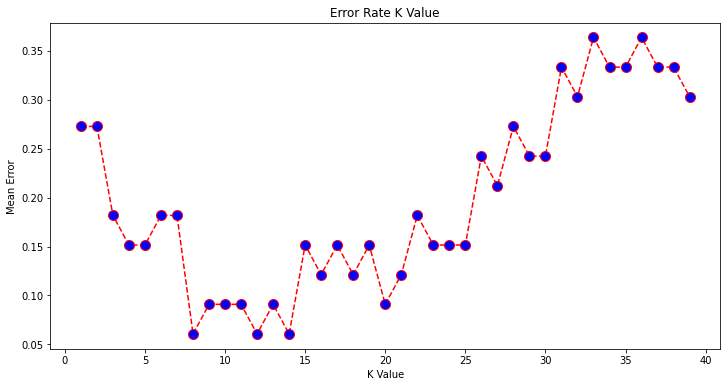

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

* From the output we can see that the mean error is zero when the value of the K is 8,12 and 14. 
* I select 8 and test the model for it.

In [66]:
classifier = KNeighborsClassifier(n_neighbors=8)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


In [67]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 4  0  0]
 [ 0 15  0]
 [ 1  1 12]]
              precision    recall  f1-score   support

        hard       0.80      1.00      0.89         4
       light       0.94      1.00      0.97        15
    moderate       1.00      0.86      0.92        14

    accuracy                           0.94        33
   macro avg       0.91      0.95      0.93        33
weighted avg       0.95      0.94      0.94        33



As we can see, the accuracy increased to 94% and it's very good.

# Actionable Insights

There are a number of conclusions we can draw from this investigation that might be helpful for the aim of the project. The most interesting insights:

* The heart rate is positively correlated with the severity of each activity, ie as the activity hardens, the heart rate also increases.
* The amount of hand temperature has a negative correlation with the difficulty of each activity, ie as the activity hardens, the hand temperature also decreases, so it can also be concluded that as the heart rate increases, the hand temperature decreases.
* hand temperature provides more information than ankle temperature and chest temperature.
* People are more able and willing to do light and moderate activities

# Summary

* The goal was to develop hardware and/or software which can determine the amount (using start/end times and heart rates) and type of physical activity carried out by an individual.
* After **reading the data**, we switched to **data cleaning**, to which we deleted the data with zero activityID, interpolated the nan data, and used the roll sum concept to make better use of the IMU features. 
* Then in **exploratory data analysis** (EDA) we dealt more with the relationship between heart rates and other characteristics and finally, we came to the conclusion that there is a positive correlation between heart rate and activity intensity.
* so we tested this issue in the **hypothesis** section and We reached this assumption correctness.
* In the last part I designed a **model** with 94% accuracy that can help software to specify the type of activity (light, moderate, hard) and its duration with the available data.